<a href="https://colab.research.google.com/github/sophiascarano/hybrid_quantum_classical_KiUNet/blob/main/kiu_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU Connect

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May 19 19:43:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Drive

Just do it manually

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Imports

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#import tensorflow_datasets as tfds
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# Set some parameters
im_width = 256
im_height = 256

# Load in data

In [5]:
train_files = []
mask_files = glob('/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_55.tif', '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_51.tif', '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_3.tif', '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_42.tif', '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_47.tif', '/cont

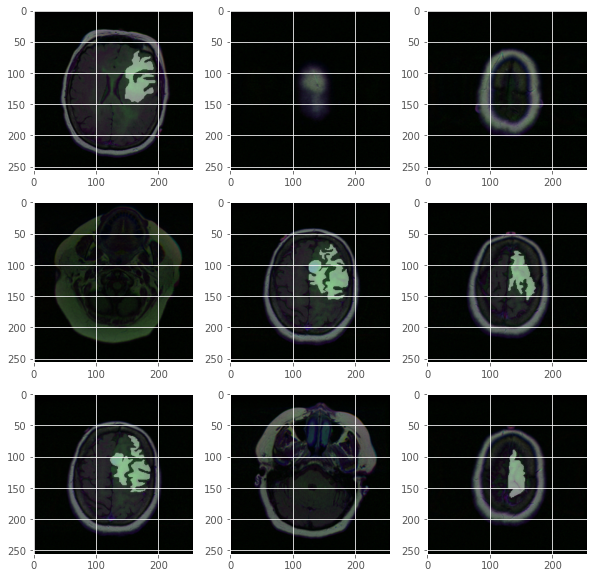

In [6]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

# Get data in usable format

In [7]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [8]:
import pandas
df = pandas.DataFrame(data={"filename": train_files, 'mask' : mask_files})

# Model

In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  # first layer
  x = input_tensor
  for i in range(1):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  return x

def encoder_block_k(inputs, n_filters, kernel_size=3, strides=(2,2), dropout=0.3):
  kf = conv2d_block(inputs, n_filters)
  kp = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(kf)
  kp = tf.keras.layers.Dropout(dropout)(kp)
  return kf, kp

def encoder_k(inputs):
  kf1, kp1 = encoder_block_k(inputs, n_filters=32)
  kf2, kp2 = encoder_block_k(kp1, n_filters=64)
  return kp2, (kf1, kf2)

def encoder_block_u(inputs, n_filters, pool_size=(2,2), dropout=0.3):
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)
  return f, p

def encoder_u(inputs):
  f1, p1 = encoder_block_u(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block_u(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block_u(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block_u(p3, n_filters=512, pool_size=(2,2), dropout=0.3)
  return p4, (f1, f2, f3, f4)
  #return p2, (f1, f2)



def decoder_block_k(inputs, conv_output, n_filters, kernel_size=(3,3), pool_size=(2,2), dropout=0.3):
  ku = conv2d_block(inputs, n_filters)
  ku = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(ku)
  kc = tf.keras.layers.concatenate([ku, conv_output])
  kc = tf.keras.layers.Dropout(dropout)(kc)
  return kc

def decoder_k(inputs, convs, output_channels):
  kf1, kf2 = convs

  kc7=inputs
  kc8 = decoder_block_k(kc7, kf2, n_filters=64, kernel_size=(3,3), dropout=0.3)
  kc9 = decoder_block_k(kc8, kf1, n_filters=32, kernel_size=(3,3), dropout=0.3)
  #outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  outputs = kc9
  return outputs

def decoder_block_u(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)
  return c

def decoder_u(inputs, convs, output_channels):
  f1, f2, f3, f4 = convs
  #f1, f2 = convs

  c6 = decoder_block_u(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block_u(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block_u(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  #c8 = decoder_block_u(inputs, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block_u(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  #outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)
  outputs = c9
  return outputs

In [10]:
OUTPUT_CHANNELS = 3

def KiteNet(input_size):
  # specify the input shape
  inputs = tf.keras.layers.Input(shape=input_size)

  # k net
  encoder_output_k, convs_k = encoder_k(inputs)
  outputs_k = decoder_k(encoder_output_k, convs_k, output_channels=OUTPUT_CHANNELS)
  
  #do 1x1 conv layer
  outputs = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, (1, 1), activation='softmax')(outputs_k)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

def UNet(input_size):
  # specify the input shape
  inputs = tf.keras.layers.Input(shape=input_size)

  # u net
  encoder_output_u, convs_u = encoder_u(inputs)
  outputs_u = decoder_u(encoder_output_u, convs_u, output_channels=OUTPUT_CHANNELS)

  #do 1x1 conv layer
  outputs = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, (1, 1), activation='softmax')(outputs_u)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

def KiUNet(input_size):
  # no CRFB yet
  # specify the input shape
  inputs = tf.keras.layers.Input(shape=input_size)

  # k net
  encoder_output_k, convs_k = encoder_k(inputs)
  outputs_k = decoder_k(encoder_output_k, convs_k, output_channels=OUTPUT_CHANNELS)

  # u net
  encoder_output_u, convs_u = encoder_u(inputs)
  outputs_u = decoder_u(encoder_output_u, convs_u, output_channels=OUTPUT_CHANNELS)

  concat_together = tf.keras.layers.concatenate([outputs_k, outputs_u])

  #do 1x1 conv layer
  outputs = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, (1, 1), activation='softmax')(concat_together)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [12]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

EPOCHS = 10
BATCH_SIZE = 4
TRAIN_SIZE = 360
TEST_SIZE = 40

train_data_frame = df.iloc[:TRAIN_SIZE]
test_data_frame = df.iloc[TRAIN_SIZE:TRAIN_SIZE+TEST_SIZE]

train_gen = train_generator(train_data_frame, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(test_data_frame, BATCH_SIZE,
                            dict(),
                            target_size=(im_height, im_width))

model = KiUNet(input_size=(im_height, im_width, 3))

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 256, 256, 64) 0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64) 0           activation_4[0][0]               
______________________________________________________________________________________________

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(train_gen,
                      steps_per_epoch=len(train_data_frame) / BATCH_SIZE, 
                      epochs=EPOCHS, 
                      validation_data = test_gener,
                      validation_steps=len(test_data_frame) / BATCH_SIZE)

Found 360 validated image filenames.
Found 360 validated image filenames.
Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.9517Found 40 validated image filenames.
Found 40 validated image filenames.
90/90 [==============================] - 499s 5s/step - loss: 0.2879 - accuracy: 0.9521 - val_loss: 0.0815 - val_accuracy: 1.0000
Epoch 2/10
90/90 [==============================] - 42s 468ms/step - loss: 0.0363 - accuracy: 0.9955 - val_loss: 0.0849 - val_accuracy: 0.9996
Epoch 3/10
90/90 [==============================] - 42s 468ms/step - loss: 0.0321 - accuracy: 0.9912 - val_loss: 0.0966 - val_accuracy: 1.0000
Epoch 4/10
90/90 [==============================] - 42s 468ms/step - loss: 0.0291 - accuracy: 0.9939 - val_loss: 0.0770 - val_accuracy: 1.0000
Epoch 5/10
90/90 [==============================] - 42s 468ms/step - loss: 0.0294 - accuracy: 0.9933 - val_loss: 0.0710 - val_accuracy: 0.9982
Epoch 6/10
90/90 [==============================] - 42s 468